In [186]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, levene
from statsmodels.stats.oneway import anova_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [187]:
# development_dataframe = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/train.csv")

development_dataframe = pd.read_csv("./input/train.csv")

# EDA

In [188]:
development_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [189]:
development_dataframe.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [190]:
train_df, val_df = train_test_split(development_dataframe, test_size=0.2, random_state=42, stratify=development_dataframe["Response"])

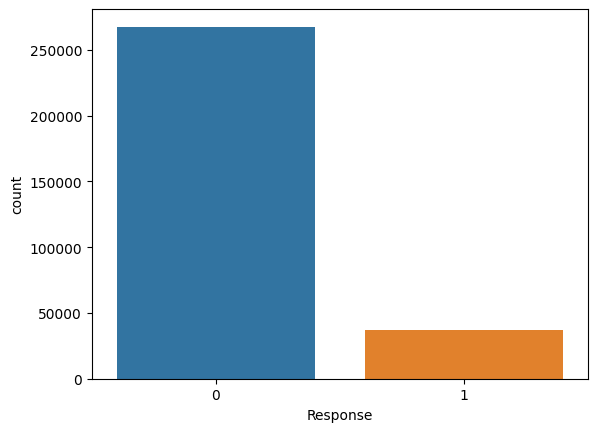

In [191]:
sns.countplot(x="Response", data=train_df)
plt.show()

### Does the gender impact on the upseling?

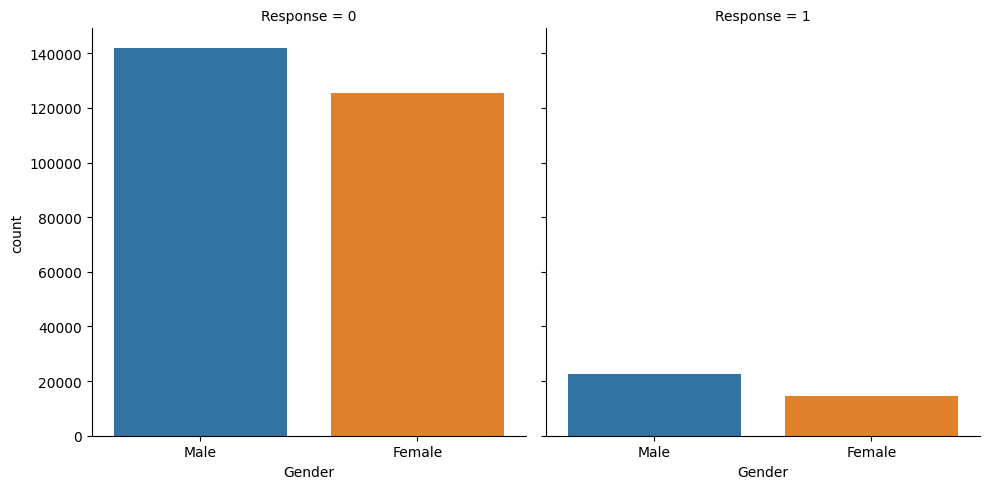

In [192]:
sns.catplot(x="Gender", col="Response", data=train_df, kind="count")
plt.show()

In [193]:
def test_categorical_independece(variables, response, data, alpha=0.05):
    dependet_variables = data[variables]
    response_data = data[response]

    insurance_response_contigency_table = pd.crosstab(dependet_variables, response_data)

    _, p_value, _, _ =chi2_contingency(insurance_response_contigency_table)

    if p_value <= alpha:
        print(f"p_value of {p_value}, distributions are dependent")
    else:
        print(f"p_value of {p_value}, distributions independent")

### Insurance predicts upseling?

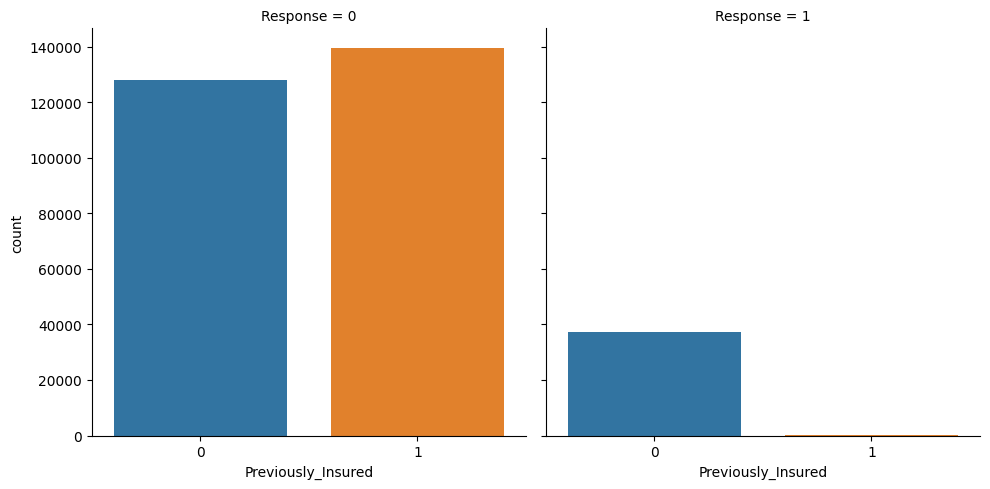

In [194]:
sns.catplot(x="Previously_Insured", col="Response", data=train_df, kind="count")
plt.show()

In [195]:
test_categorical_independece(variables="Previously_Insured", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Understand the impact of vehicle age

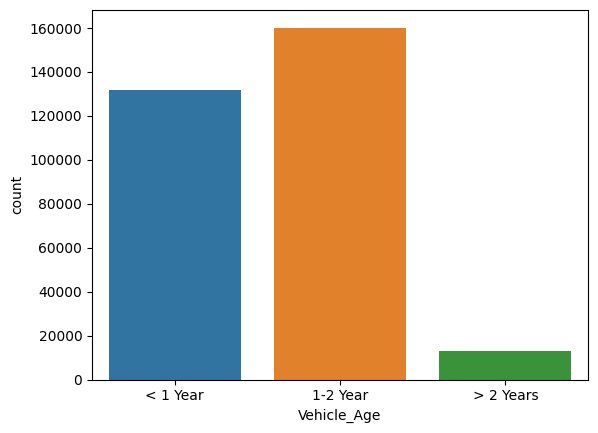

In [196]:
sns.countplot(x="Vehicle_Age", data=train_df)
plt.show()

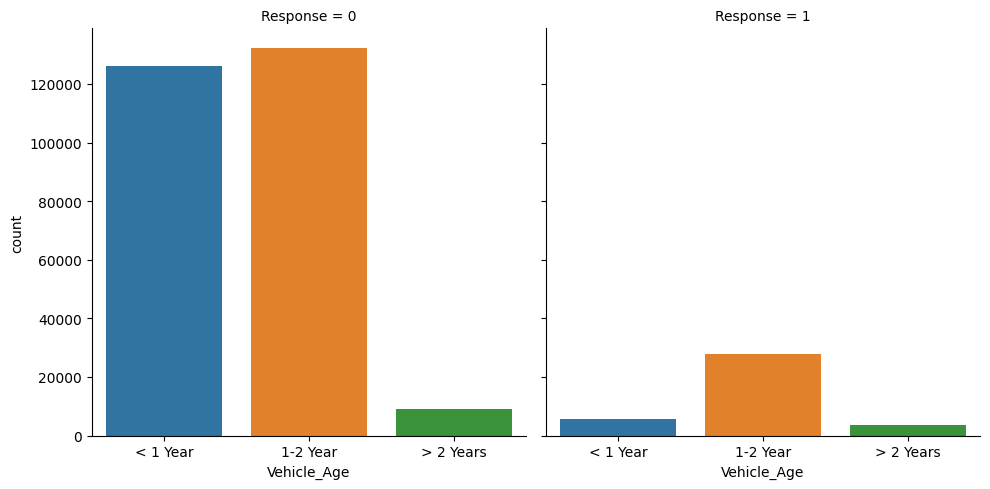

In [197]:
sns.catplot(x="Vehicle_Age", col="Response", data=train_df, kind="count")
plt.show()

In [198]:
test_categorical_independece(variables="Vehicle_Age", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Understand the impact of vehicle damage on upseling

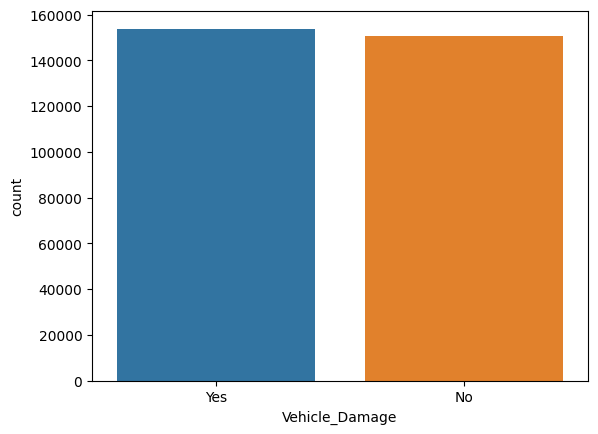

In [199]:
sns.countplot(x="Vehicle_Damage", data=train_df)
plt.show()

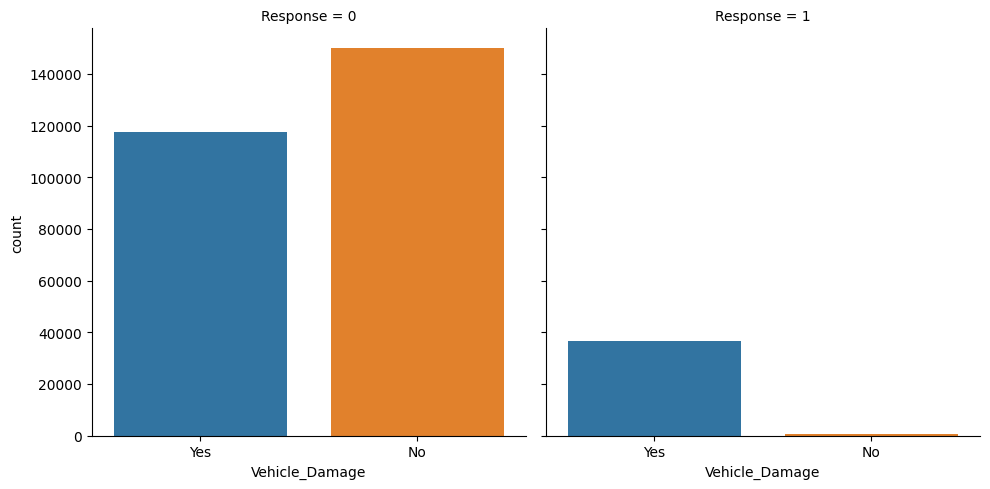

In [200]:
sns.catplot(x="Vehicle_Damage", col="Response", data=train_df, kind="count")
plt.show()

In [201]:
test_categorical_independece(variables="Vehicle_Damage", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


### Driving license

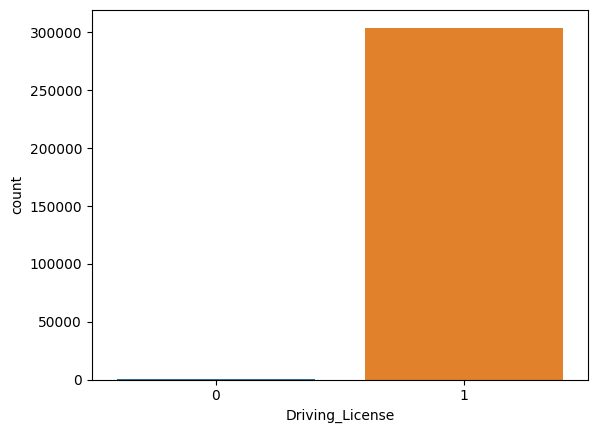

1    0.997855
0    0.002145
Name: Driving_License, dtype: float64

In [202]:
sns.countplot(x="Driving_License", data=train_df)
plt.show()

train_df["Driving_License"].value_counts(normalize=True)

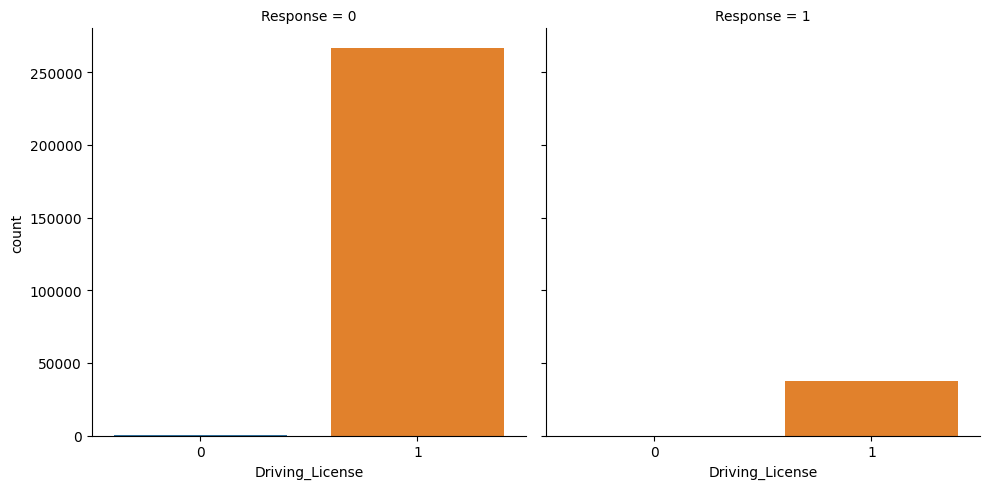

Driving_License  Response
0                0           0.948012
                 1           0.051988
1                0           0.877285
                 1           0.122715
Name: Response, dtype: float64

In [203]:
sns.catplot(x="Driving_License", col="Response", data=train_df, kind="count")
plt.show()

train_df.groupby("Driving_License")["Response"].value_counts(normalize=True)

In [204]:
test_categorical_independece(variables="Driving_License", response="Response", data=train_df)

p_value of 5.038720780124752e-08, distributions are dependent


### Check if premium impacts on upseling

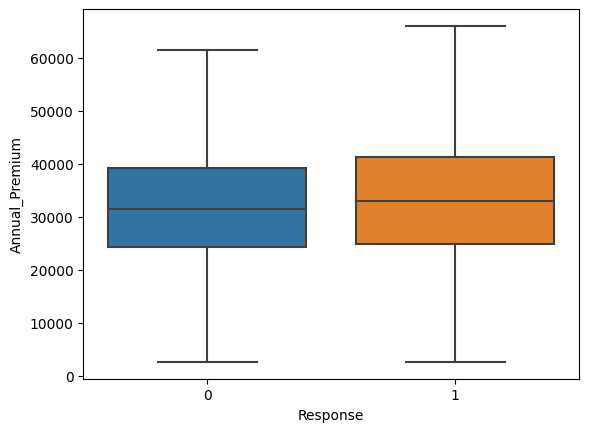

In [205]:
sns.boxplot(x="Response", y="Annual_Premium", showfliers=False, data=train_df)
plt.show()

In [206]:
train_df.groupby("Response")["Annual_Premium"].mean()

Response
0    30447.711157
1    31619.326054
Name: Annual_Premium, dtype: float64

In [207]:
no_cross_sell_premium = train_df.query("Response==0")["Annual_Premium"]
cross_sell_premium = train_df.query("Response==1")["Annual_Premium"]

_, p_value = ttest_ind(no_cross_sell_premium, cross_sell_premium, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Age impact

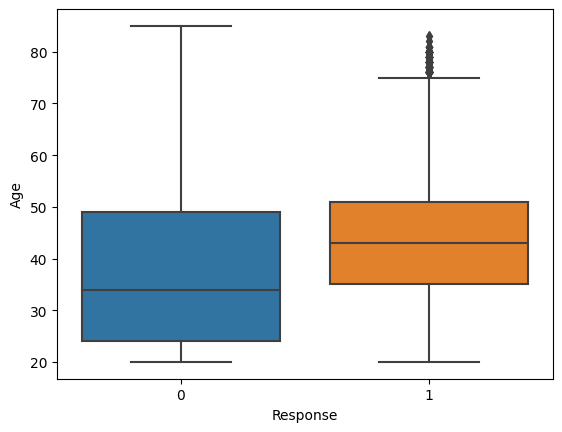

In [208]:
sns.boxplot(x="Response", y="Age", data=train_df)
plt.show()

In [209]:
no_cross_sell_age= train_df.query("Response==0")["Age"]
cross_sell_age = train_df.query("Response==1")["Age"]

_, p_value = ttest_ind(no_cross_sell_age, cross_sell_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Policy sales channel

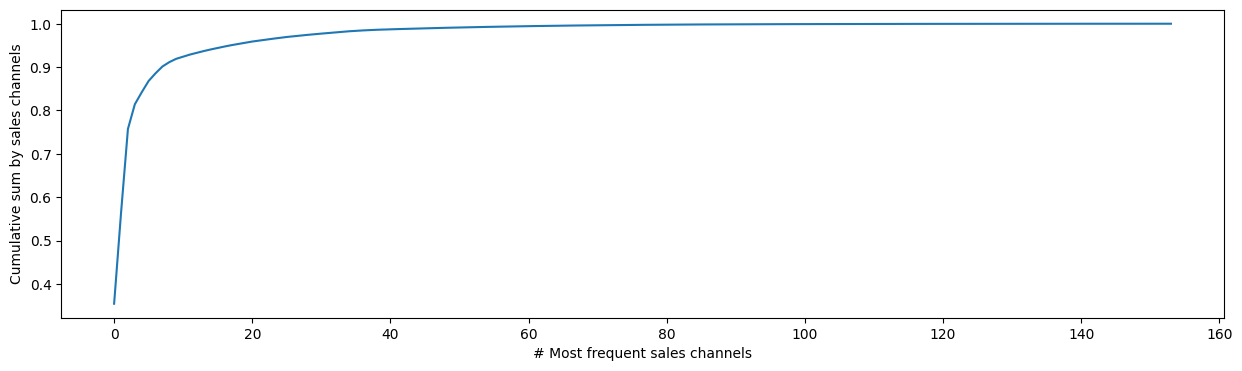

In [210]:
frequency_sales_channels = train_df["Policy_Sales_Channel"].value_counts(normalize=True)

cumulative_frequency_sales_channels = np.cumsum(frequency_sales_channels)
index = np.arange(len(frequency_sales_channels))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_frequency_sales_channels, ax=ax)

ax.set_xlabel("# Most frequent sales channels")
ax.set_ylabel("Cumulative sum by sales channels")

plt.show()

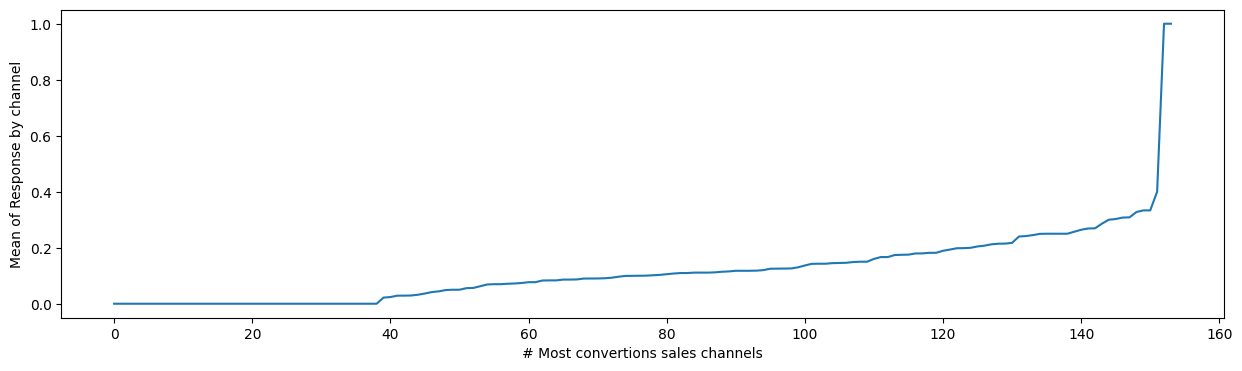

In [211]:
mean_response_by_sales_channel = train_df.groupby("Policy_Sales_Channel")["Response"].mean().sort_values()

mean_response_by_sales_channel.name="mean_response_by_sales_channel"

mean_response_by_sales_channel_values = mean_response_by_sales_channel.values
index = np.arange(len(mean_response_by_sales_channel))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_sales_channel_values, ax=ax)

ax.set_xlabel("# Most convertions sales channels")
ax.set_ylabel("Mean of Response by channel")

plt.show()

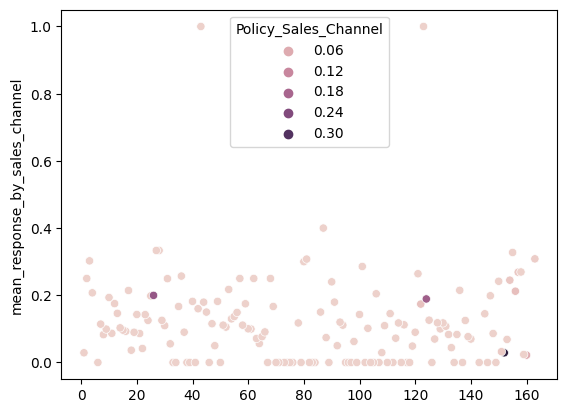

In [212]:
mean_response_and_frequency_by_sales_channel = pd.merge(mean_response_by_sales_channel, frequency_sales_channels, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_sales_channel.index, y="mean_response_by_sales_channel", hue="Policy_Sales_Channel", data=mean_response_and_frequency_by_sales_channel)

plt.show()

In [213]:
most_frequent_sales_channels = cumulative_frequency_sales_channels[cumulative_frequency_sales_channels < 0.9].index

### Analyse vintage

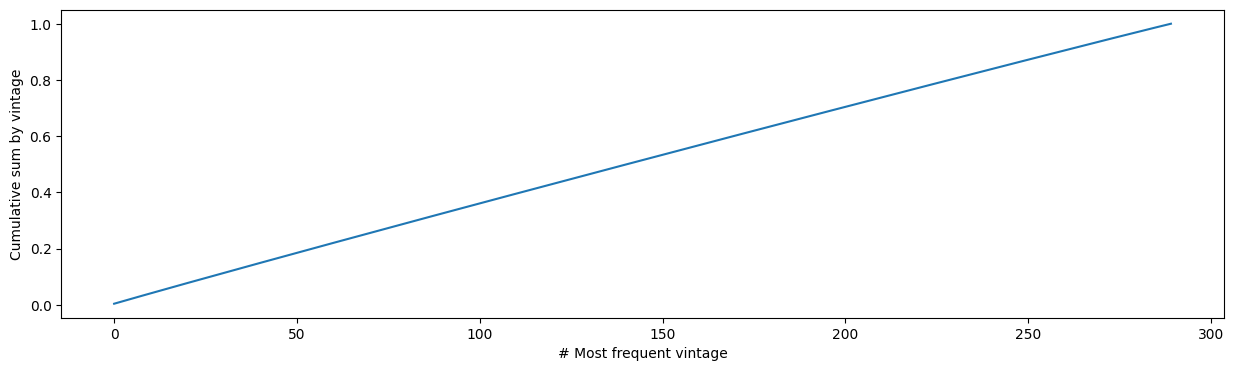

In [214]:
frequency_vintage = train_df["Vintage"].value_counts(normalize=True)

cumulative_vintage = np.cumsum(frequency_vintage)
index = np.arange(len(cumulative_vintage))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_vintage, ax=ax)

ax.set_xlabel("# Most frequent vintage")
ax.set_ylabel("Cumulative sum by vintage")

plt.show()

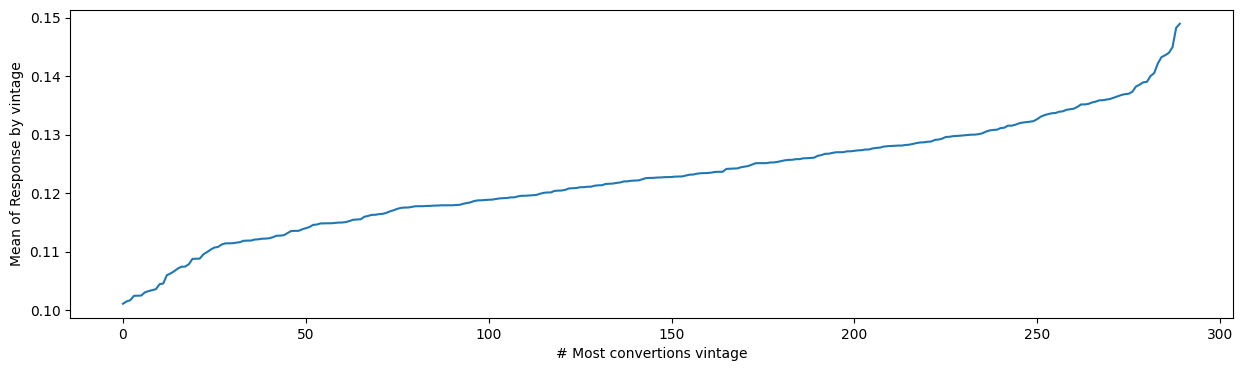

In [215]:
mean_response_by_vintage = train_df.groupby("Vintage")["Response"].mean().sort_values()

mean_response_by_vintage_values = mean_response_by_vintage.values
index = np.arange(len(mean_response_by_vintage))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_vintage_values, ax=ax)

ax.set_xlabel("# Most convertions vintage")
ax.set_ylabel("Mean of Response by vintage")

plt.show()

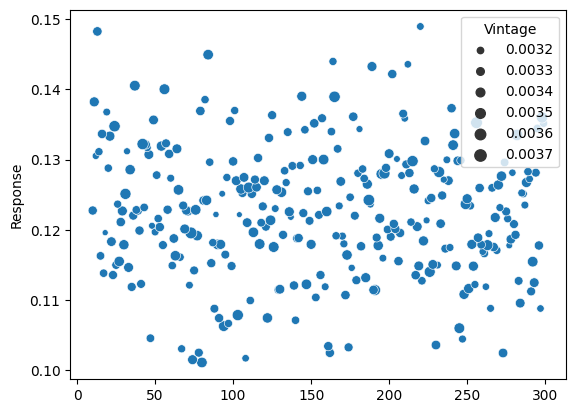

In [216]:
mean_response_and_frequency_by_vintage = pd.merge(mean_response_by_vintage, frequency_vintage, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_vintage.index, y="Response", size="Vintage", data=mean_response_and_frequency_by_vintage)

plt.show()

In [217]:
test_categorical_independece(variables="Vintage", response="Response", data=train_df)

p_value of 0.9825945874525271, distributions independent


### Analyse region code

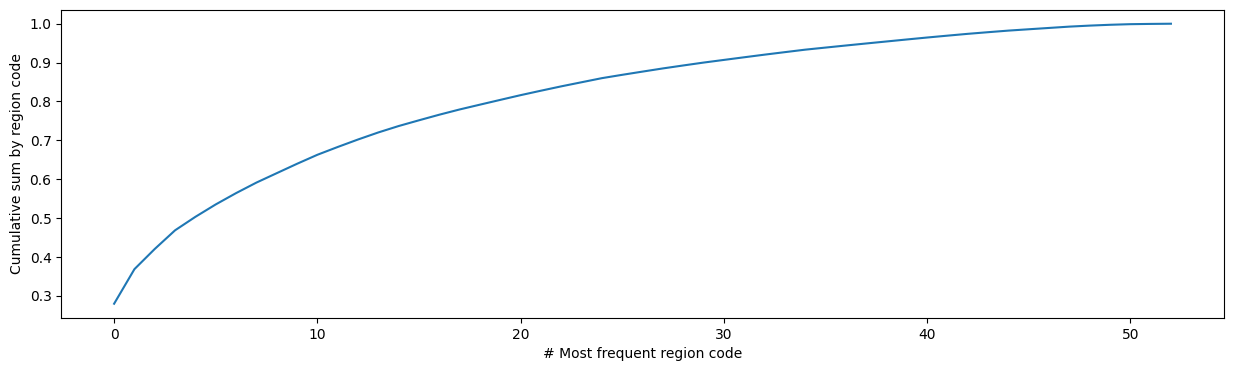

In [218]:
frequency_region_code = train_df["Region_Code"].value_counts(normalize=True)

cumulative_frequency_region_code = np.cumsum(frequency_region_code)
index = np.arange(len(frequency_region_code))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=cumulative_frequency_region_code, ax=ax)

ax.set_xlabel("# Most frequent region code")
ax.set_ylabel("Cumulative sum by region code")

plt.show()

In [219]:
frequency_region_code = train_df["Region_Code"].value_counts(normalize=True)


In [220]:
frequency_region_code

28.0    0.279290
8.0     0.089010
46.0    0.051977
41.0    0.048001
15.0    0.034692
30.0    0.031923
29.0    0.029080
50.0    0.027079
11.0    0.024225
3.0     0.024173
36.0    0.023173
33.0    0.020070
47.0    0.019289
35.0    0.018181
6.0     0.016491
45.0    0.014769
37.0    0.014395
18.0    0.013484
14.0    0.012382
48.0    0.012287
39.0    0.012159
10.0    0.011460
21.0    0.011201
2.0     0.010555
13.0    0.010548
7.0     0.008590
12.0    0.008285
9.0     0.008160
27.0    0.007606
32.0    0.007426
17.0    0.006848
26.0    0.006819
43.0    0.006737
24.0    0.006452
25.0    0.006386
38.0    0.005376
0.0     0.005323
16.0    0.005222
23.0    0.005159
31.0    0.005149
20.0    0.005044
49.0    0.004789
4.0     0.004690
34.0    0.004228
19.0    0.004093
22.0    0.003450
40.0    0.003408
5.0     0.003401
1.0     0.002611
44.0    0.002119
42.0    0.001558
52.0    0.000699
51.0    0.000479
Name: Region_Code, dtype: float64

In [221]:
pd.merge(train_df, frequency_region_code, left_on="Region_Code", right_index=True )

,Region_Code,id,Gender,Age,Driving_License,Region_Code_x,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Code_y
274710,40.0,274711,Male,22,1,40.0,0,< 1 Year,Yes,25455.0,152.0,203,0,0.003408
202387,40.0,202388,Female,24,1,40.0,0,< 1 Year,Yes,29192.0,152.0,58,0,0.003408
353922,40.0,353923,Female,39,1,40.0,0,1-2 Year,Yes,2630.0,157.0,216,0,0.003408
158554,40.0,158555,Female,52,1,40.0,1,1-2 Year,No,27716.0,124.0,163,0,0.003408
57497,40.0,57498,Female,29,1,40.0,1,1-2 Year,No,31509.0,124.0,274,0,0.003408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94752,51.0,94753,Male,29,1,51.0,0,< 1 Year,Yes,2630.0,26.0,222,0,0.000479
317625,51.0,317626,Male,34,1,51.0,0,1-2 Year,Yes,2630.0,156.0,72,0,0.000479
199031,51.0,199032,Male,21,1,51.0,0,< 1 Year,Yes,2630.0,153.0,181,0,0.000479
49557,51.0,49558,Male,58,1,51.0,0,1-2 Year,Yes,28561.0,26.0,134,0,0.000479


In [222]:
region_codes = train_df["Region_Code"]
region_codes

274710    40.0
216539     8.0
78983     28.0
218368    37.0
307215    28.0
          ... 
378816    47.0
67726     28.0
91744     28.0
48700      8.0
221791    15.0
Name: Region_Code, Length: 304887, dtype: float64

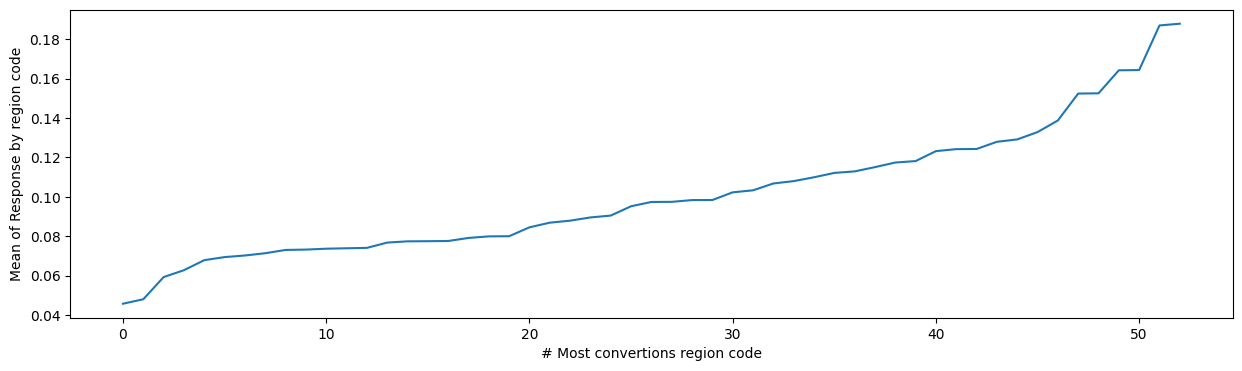

In [223]:
mean_response_by_region_code = train_df.groupby("Region_Code")["Response"].mean().sort_values()

mean_response_by_region_code.name="mean_response_by_region_code"

mean_response_by_region_code_values = mean_response_by_region_code.values
index = np.arange(len(mean_response_by_region_code))

fig, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=index, y=mean_response_by_region_code_values, ax=ax)

ax.set_xlabel("# Most convertions region code")
ax.set_ylabel("Mean of Response by region code")

plt.show()

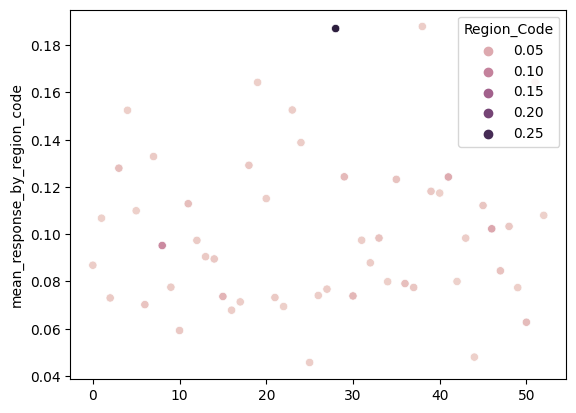

In [224]:
mean_response_and_frequency_by_region_code = pd.merge(mean_response_by_region_code, frequency_region_code, left_index=True, right_index=True)

sns.scatterplot(x=mean_response_and_frequency_by_region_code.index, y="mean_response_by_region_code", hue="Region_Code", data=mean_response_and_frequency_by_region_code)

plt.show()

In [225]:
test_categorical_independece(variables="Region_Code", response="Response", data=train_df)

p_value of 0.0, distributions are dependent


In [226]:
most_frequent_region_code = cumulative_frequency_region_code[cumulative_frequency_region_code < 0.9].index

## Draw relation between variables

### Age and Vehicule damage

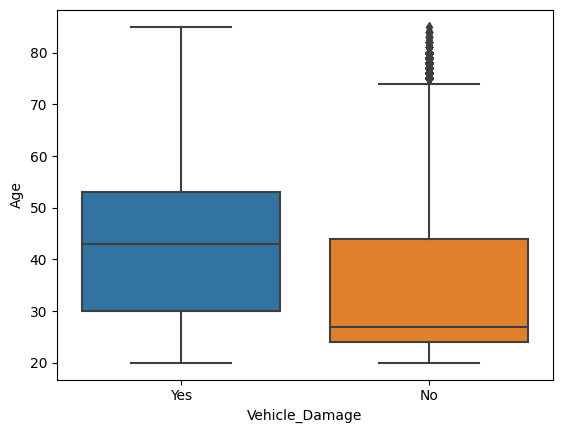

In [227]:
sns.boxplot(x="Vehicle_Damage", y="Age", data=train_df)
plt.show()

In [228]:
no_damage_age= train_df.query("Vehicle_Damage=='No'")["Age"]
damage_age = train_df.query("Vehicle_Damage=='Yes'")["Age"]

_, p_value = ttest_ind(no_damage_age, damage_age, equal_var=False, random_state=42, permutations=100)

alpha = 0.05

if p_value < alpha:
    print(f"p_value of {p_value}, distributions don't have equal means")
else:
    print(f"p_value of {p_value}, can't say if distributions have different means")

p_value of 0.0, distributions don't have equal means


### Impact of gender of vehicle damage

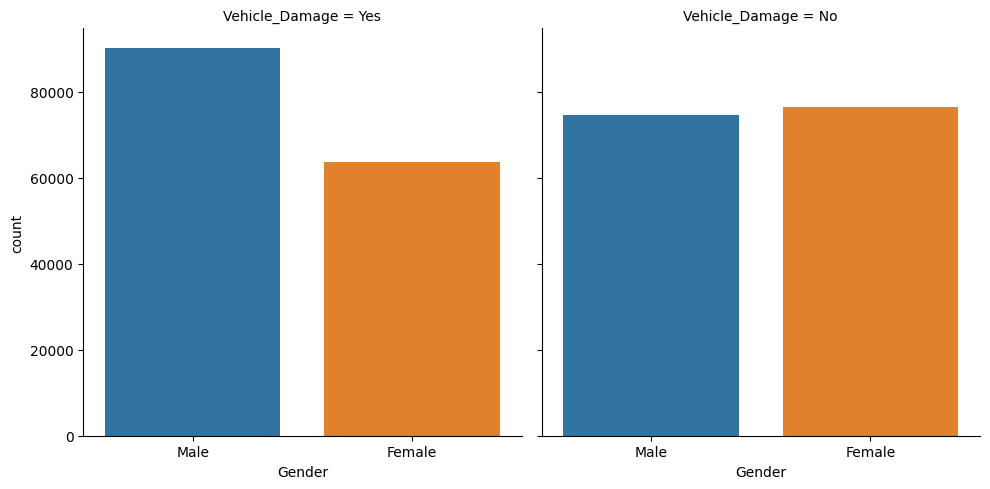

In [229]:
sns.catplot(x="Gender", col="Vehicle_Damage", data=train_df, kind="count")
plt.show()

In [230]:
test_categorical_independece(variables="Gender", response="Vehicle_Damage", data=train_df)

p_value of 0.0, distributions are dependent


### Correlation between age and premium

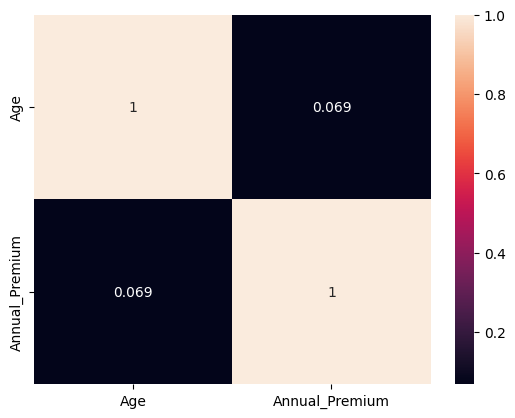

In [231]:
age_premium_correlation = train_df[["Age", "Annual_Premium"]].corr()

sns.heatmap(age_premium_correlation, annot=True)
plt.show()

### Relation between vehicle age and premium

In [232]:
less_one_year_premium = train_df.query("Vehicle_Age=='< 1 Year'")["Annual_Premium"]
one_two_year_premium = train_df.query("Vehicle_Age=='1-2 Year'")["Annual_Premium"]
more_two_year_premium = train_df.query("Vehicle_Age=='> 2 Years'")["Annual_Premium"]

In [233]:
print(np.var(less_one_year_premium))
print(np.var(one_two_year_premium))
print(np.var(more_two_year_premium))

223003677.89615294
346471718.5069917
414875703.710784


In [234]:
_, p_value = levene(less_one_year_premium, one_two_year_premium, more_two_year_premium)

if p_value < 0.05:
    print(f"p value of {p_value}, variables do not have equal variance")
else:
    print(f"p value of {p_value}, variables have equal variance")

p value of 0.0, variables do not have equal variance


In [235]:
_, p_value = anova_oneway((less_one_year_premium, one_two_year_premium, more_two_year_premium), use_var="unequal")

if p_value < 0.05:
    print(f"p value {p_value:.3f}, premium is not equal between vehicle age")
else:
    print(f"p value {p_value:.3f}, premium is equal between vehicle age")

p value 0.000, premium is not equal between vehicle age


# Model Development

## Baseline model

In [236]:
baseline_features = ["Policy_Sales_Channel", "Vehicle_Damage", "Vehicle_Age", "Previously_Insured", "Gender"]

y_train = train_df["Response"].values
features_df_baseline = train_df[baseline_features].copy()

In [237]:
def map_features(dataframe, mapper):

    for key, value in mapper.items():
        dataframe[key] = dataframe[key].map(value)

    return dataframe

In [238]:
baseline_features_mapper = {
    "Vehicle_Damage": {"No": 0, "Yes": 1},
    "Vehicle_Age": {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2},
    "Gender": {"Male": 0, "Female": 1},
}


features_df_baseline = map_features(features_df_baseline, baseline_features_mapper)

X_train_baseline = features_df_baseline.values

### Evaluate logistic regression

In [239]:
logreg = LogisticRegression(class_weight="balanced")

logreg.fit(X_train_baseline, y_train)

LogisticRegression(class_weight='balanced')

In [240]:
y_val = val_df["Response"].values

features_val_baseline = val_df[baseline_features].copy()

features_val_baseline = map_features(features_val_baseline, baseline_features_mapper)

X_val_baseline = features_val_baseline.values

In [241]:
y_pred_logreg_baseline = logreg.predict(X_val_baseline)

print(classification_report(y_val, y_pred_logreg_baseline))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.98      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



## Engineer features

In [242]:
def compute_frequencies(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        frequencies = dataframe_to_compute_statistics[category].value_counts(normalize=True)
        frequencies.name = f"Frequencies_{category}"

        list_categories = dataframe[category]

        frequency_by_category = pd.merge(list_categories, frequencies, left_on=category, right_index=True )

        result_dataframe[f"Frequencies_{category}"] = frequency_by_category[f"Frequencies_{category}"]
        
    return result_dataframe

In [243]:
def compute_mean_response(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        mean_response = dataframe_to_compute_statistics.groupby(category)["Response"].mean()
        mean_response.name = f"Mean_Response_{category}"

        list_categories = dataframe[category]

        mean_response_by_category = pd.merge(list_categories, mean_response, left_on=category, right_index=True )

        result_dataframe[f"Mean_Response_{category}"] = mean_response_by_category[f"Mean_Response_{category}"]
        
    return result_dataframe

In [244]:
def covalence_categories(dataframe, categories, dataframe_to_compute_statistics):
    result_dataframe = dataframe.copy()

    for category in categories:
        frequencies = dataframe_to_compute_statistics[category].value_counts(normalize=True)
        cumulative_frequencies = np.cumsum(frequencies)

        most_frequent = frequencies[cumulative_frequencies < 0.9].index

        is_most_frequent = dataframe[category].isin(most_frequent)

        result_dataframe[f"Is_Frequent_{category}"] = dataframe[category].loc[is_most_frequent]

    return result_dataframe

In [245]:
categories_to_covalence = ["Policy_Sales_Channel", "Region_Code"]


train_df_engineered = compute_frequencies(train_df, categories_to_covalence, train_df)
val_df_engineered = compute_frequencies(val_df, categories_to_covalence, train_df)

train_df_engineered = compute_mean_response(train_df_engineered, categories_to_covalence, train_df)
val_df_engineered = compute_mean_response(val_df_engineered, categories_to_covalence, train_df)


train_df_engineered = covalence_categories(train_df_engineered, categories_to_covalence, train_df)
val_df_engineered = covalence_categories(train_df_engineered, categories_to_covalence, train_df)

In [246]:
train_df_engineered = train_df_engineered.fillna(0)
val_df_engineered = val_df_engineered.fillna(0)

## Train models

In [264]:
feature_columns = ["Frequencies_Policy_Sales_Channel", "Mean_Response_Policy_Sales_Channel", "Vehicle_Damage", "Vehicle_Age", "Previously_Insured", "Gender", "Frequencies_Region_Code", "Mean_Response_Region_Code"]

y_train = train_df_engineered["Response"].values
features_df = train_df_engineered[feature_columns].copy()

In [265]:
features_mapper = {
    "Vehicle_Damage": {"No": 0, "Yes": 1},
    "Vehicle_Age": {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2},
    "Gender": {"Male": 0, "Female": 1},
}

features_df = map_features(features_df, features_mapper)

In [266]:
X_train = features_df.values

### Train logistic regression

In [267]:
logreg = LogisticRegression(class_weight="balanced")

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Train random forrest

In [268]:
forrest = RandomForestClassifier(class_weight="balanced")

forrest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

## Validating models

### Prepare validation data

In [269]:
val_df_engineered["Response"].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

In [270]:
y_val = val_df_engineered["Response"].values

features_val = val_df_engineered[feature_columns].copy()

features_val = map_features(features_val, features_mapper)

In [271]:
X_val = features_val.values

### Evaluate logistic regression

In [272]:
y_pred_logreg = logreg.predict(X_val)

print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267519
           1       0.28      0.93      0.43     37368

    accuracy                           0.69    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.69      0.74    304887



### Evaluate random forrest

In [273]:
y_pred_forrest = forrest.predict(X_train)

print(classification_report(y_train, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81    267519
           1       0.29      0.93      0.44     37368

    accuracy                           0.71    304887
   macro avg       0.64      0.81      0.62    304887
weighted avg       0.90      0.71      0.76    304887



In [274]:
y_pred_forrest = forrest.predict(X_val)

print(classification_report(y_val, y_pred_forrest))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81    267519
           1       0.29      0.93      0.44     37368

    accuracy                           0.71    304887
   macro avg       0.64      0.81      0.62    304887
weighted avg       0.90      0.71      0.76    304887



## Deal with imbalance using smote

In [259]:
# balancer = SMOTE()

In [260]:
# X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_train)

In [261]:
# forrest = RandomForestClassifier()

# forrest.fit(X_train_balanced, y_train_balanced)

In [262]:
# y_pred_forrest = forrest.predict(X_train_balanced)

# print(classification_report(y_train_balanced, y_pred_forrest))

In [263]:
# y_pred_forrest = forrest.predict(X_val)

# print(classification_report(y_val, y_pred_forrest))